In [1]:
import os
import cv2
import numpy as np
from matplotlib import pyplot as plt
import random
import tensorflow as tf
from collections import deque

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [2]:
dataset_path = "C:/Users/batuh/Downloads/Compressed/Dataset_3"
actions = os.listdir(dataset_path)

In [3]:
frame_count = 20

frame_width = 64
frame_height = 64

seed_constant = 86
np.random.seed(seed_constant)
random.seed(seed_constant)
tf.random.set_seed(seed_constant)

In [4]:
def take_video_names(dataset_path):

  actions = os.listdir(dataset_path)
  video_paths = []
  video_labels = []

  for single_action in actions:

    videos = os.listdir(dataset_path + "/" + single_action)

    for single_video in videos:

      single_video_path = dataset_path + "/" + single_action + "/" + single_video

      video_paths.append(single_video_path)
      video_labels.append(single_action)

  print(f"There is {len(actions)} action in the dataset.")
  print(f"There is {len(video_paths)} video in the dataset\n")

  return np.array(video_paths), np.array(video_labels)

In [5]:
def zoom_at(img, zoom=1, angle=0, coord=None):
    
    cy, cx = [ i/2 for i in img.shape[:-1] ] if coord is None else coord[::-1]
    
    rot_mat = cv2.getRotationMatrix2D((cx,cy), angle, zoom)
    result = cv2.warpAffine(img, rot_mat, img.shape[1::-1], flags=cv2.INTER_LINEAR)
    
    return result

In [6]:
def video_preprocess(frame):

  resized_frame = cv2.resize(frame, (frame_height, frame_width))

  normalized_frame = resized_frame / 255

  return normalized_frame

In [7]:
def load_video (video_path):

  frames_list = []

  cap = cv2.VideoCapture(video_path)

  ok, frame = cap.read()

  video_frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

  skip_ratio = max(int(video_frame_count/frame_count), 1)

  for i in range(frame_count):

    cap.set(cv2.CAP_PROP_POS_FRAMES, i * skip_ratio)

    oke, frame = cap.read()

    if not oke:
      break

    frame = zoom_at(frame, 1.5)
    frame = frame[:,560:1360]
    print(frame.shape)
    cv2.imshow('asddsa', frame)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

    frame = video_preprocess(frame)

    frames_list.append(frame)

  if len(frames_list) != frame_count:
    print(f"There is not enough number of frames in this video {video_path}")

  cap.release()

  return frames_list

In [8]:
feature_s = []

count = 0

videos, labels = take_video_names(dataset_path)

for one_video in videos:

  count = count + 1

  feature_s.append(load_video(one_video))

  print (f"{count/len(videos)*100} percent complete ")

feature_s = np.array(feature_s)

There is 4 action in the dataset.
There is 1776 video in the dataset

(1080, 800, 3)
(1080, 800, 3)
(1080, 800, 3)
(1080, 800, 3)
(1080, 800, 3)
(1080, 800, 3)
(1080, 800, 3)
(1080, 800, 3)
(1080, 800, 3)
(1080, 800, 3)
(1080, 800, 3)
(1080, 800, 3)
(1080, 800, 3)
(1080, 800, 3)
(1080, 800, 3)
(1080, 800, 3)
(1080, 800, 3)
(1080, 800, 3)
(1080, 800, 3)
(1080, 800, 3)
0.05630630630630631 percent complete 
(1080, 800, 3)
(1080, 800, 3)
(1080, 800, 3)
(1080, 800, 3)
(1080, 800, 3)
(1080, 800, 3)
(1080, 800, 3)
(1080, 800, 3)
(1080, 800, 3)
(1080, 800, 3)
(1080, 800, 3)
(1080, 800, 3)
(1080, 800, 3)
(1080, 800, 3)
(1080, 800, 3)
(1080, 800, 3)
(1080, 800, 3)
(1080, 800, 3)
(1080, 800, 3)
(1080, 800, 3)
0.11261261261261261 percent complete 
(1080, 800, 3)
(1080, 800, 3)
(1080, 800, 3)
(1080, 800, 3)
(1080, 800, 3)
(1080, 800, 3)
(1080, 800, 3)
(1080, 800, 3)
(1080, 800, 3)
(1080, 800, 3)
(1080, 800, 3)
(1080, 800, 3)
(1080, 800, 3)
(1080, 800, 3)
(1080, 800, 3)
(1080, 800, 3)
(1080, 800, 3)

In [ ]:
print(len(feature_s))
print(type(feature_s))

1776
<class 'numpy.ndarray'>


In [ ]:
le = LabelEncoder()
labels = le.fit_transform(labels)

one_hot_encoded_labels = to_categorical(labels)

In [ ]:
features_train, features_test, labels_train, labels_test = train_test_split(feature_s, 
                                                                            one_hot_encoded_labels,
                                                                            test_size = 0.25,
                                                                            shuffle = True,
                                                                            random_state = seed_constant)

In [ ]:
del feature_s
del labels
del count

In [ ]:
def create_LRCN_model():

    model = Sequential()
    
    model.add(TimeDistributed(Conv2D(16, (3, 3), padding='same',activation = 'relu'),
                              input_shape = (frame_count, frame_height, frame_width, 3)))
    
    model.add(TimeDistributed(MaxPooling2D((4, 4))))
    model.add(TimeDistributed(Dropout(0.25)))
    
    model.add(TimeDistributed(Conv2D(32, (3, 3), padding='same',activation = 'relu')))
    model.add(TimeDistributed(MaxPooling2D((4, 4))))
    model.add(TimeDistributed(Dropout(0.25)))
    
    model.add(TimeDistributed(Conv2D(64, (3, 3), padding='same',activation = 'relu')))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    model.add(TimeDistributed(Dropout(0.25)))
    
    model.add(TimeDistributed(Conv2D(64, (3, 3), padding='same',activation = 'relu')))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
                                      
    model.add(TimeDistributed(Flatten()))
                                      
    model.add(LSTM(32))
                                      
    model.add(Dense(len(actions), activation = 'softmax'))


    model.summary()
    
    return model

In [ ]:
LRCN_model = create_LRCN_model()

print("Model Created Successfully!")

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed (TimeDistri (None, 20, 64, 64, 16)    448       
_________________________________________________________________
time_distributed_1 (TimeDist (None, 20, 16, 16, 16)    0         
_________________________________________________________________
time_distributed_2 (TimeDist (None, 20, 16, 16, 16)    0         
_________________________________________________________________
time_distributed_3 (TimeDist (None, 20, 16, 16, 32)    4640      
_________________________________________________________________
time_distributed_4 (TimeDist (None, 20, 4, 4, 32)      0         
_________________________________________________________________
time_distributed_5 (TimeDist (None, 20, 4, 4, 32)      0         
_________________________________________________________________
time_distributed_6 (TimeDist (None, 20, 4, 4, 64)      1

In [ ]:
early_stopping_callback = EarlyStopping(monitor = 'val_loss', patience = 60, mode = 'min', restore_best_weights = True)

LRCN_model.compile(loss = 'categorical_crossentropy', optimizer = 'Adam', metrics = ["accuracy"])

LRCN_model_training_history = LRCN_model.fit(x = features_train, y = labels_train, epochs = 70, batch_size = 4 ,
                                             shuffle = True, validation_split = 0.2, 
                                             callbacks = [early_stopping_callback])

Epoch 1/70
267/267 [==============================] - 12s 14ms/step - loss: 1.3994 - accuracy: 0.2404 - val_loss: 1.3899 - val_accuracy: 0.2210
Epoch 2/70
267/267 [==============================] - 3s 10ms/step - loss: 1.3698 - accuracy: 0.2939 - val_loss: 1.3407 - val_accuracy: 0.3521
Epoch 3/70
267/267 [==============================] - 3s 10ms/step - loss: 1.0680 - accuracy: 0.5202 - val_loss: 0.7664 - val_accuracy: 0.5843
Epoch 4/70
267/267 [==============================] - 3s 10ms/step - loss: 0.8656 - accuracy: 0.5953 - val_loss: 0.6296 - val_accuracy: 0.6667
Epoch 5/70
267/267 [==============================] - 3s 10ms/step - loss: 0.6511 - accuracy: 0.6854 - val_loss: 0.5999 - val_accuracy: 0.7116
Epoch 6/70
267/267 [==============================] - 3s 10ms/step - loss: 0.6074 - accuracy: 0.6911 - val_loss: 0.6104 - val_accuracy: 0.6517
Epoch 7/70
267/267 [==============================] - 3s 10ms/step - loss: 0.5680 - accuracy: 0.7099 - val_loss: 0.6058 - val_accuracy: 0.685

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


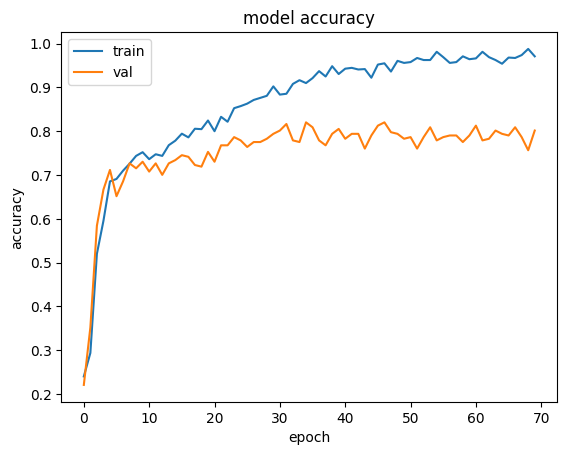

In [ ]:
print(LRCN_model_training_history.history.keys())
plt.plot(LRCN_model_training_history.history['accuracy'])
plt.plot(LRCN_model_training_history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

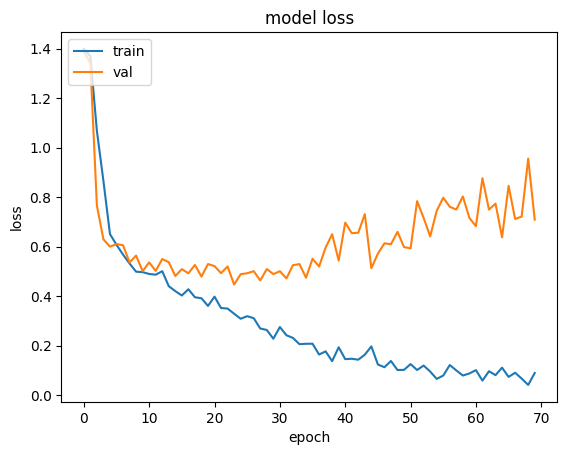

In [ ]:
plt.plot(LRCN_model_training_history.history['loss'])
plt.plot(LRCN_model_training_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
model_evaluation_history = LRCN_model.evaluate(features_test, labels_test)

14/14 [==============================] - 1s 27ms/step - loss: 0.8243 - accuracy: 0.7928


In [ ]:
# del LRCN_model

In [ ]:
Y_test = np.argmax(labels_test, axis=1) # Convert one-hot to index
y_pred = np.argmax(LRCN_model.predict(features_test), axis=-1)
print(classification_report(Y_test, y_pred))

print('\n')
print(actions[3])

              precision    recall  f1-score   support

           0       0.63      0.70      0.66       120
           1       0.98      0.94      0.96       119
           2       0.97      0.95      0.96       103
           3       0.61      0.57      0.59       102

    accuracy                           0.79       444
   macro avg       0.80      0.79      0.79       444
weighted avg       0.80      0.79      0.79       444



wave


In [ ]:
def predict_on_camera():

    cam = cv2.VideoCapture(0)
    
    cam_frame_list = deque(maxlen = frame_count)

    while True:

        ok, cam_frame = cam.read()
    
        if ok == True:
        
            normalized_cam_frame = video_preprocess(cam_frame)

            cam_frame_list.append(normalized_cam_frame)

        if len(cam_frame_list) == 20:

            predicted_labels_probabilities = LRCN_model.predict(np.expand_dims(cam_frame_list, axis = 0))[0]
            
            for i in range(len(actions)):
                
                if predicted_labels_probabilities[i] > 0.95 and predicted_labels_probabilities[i] < 1.0:
                    
                    predicted_label = np.argmax(predicted_labels_probabilities)

                    predicted_class_name = actions[predicted_label]

                    cv2.putText(cam_frame, predicted_class_name, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
            
        cv2.imshow("Frame", cam_frame)
        
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
            
    cam.release()

In [ ]:
while True:
    
    predict_on_camera()